# Machine Learning Module (MLlib)


## Advanced Feature Engineering

### Import Libraries

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.regression import GeneralizedLinearRegression

### Start spark session

**Strategy**

* We will initialize a Spark session named `"nyc_yellow_taxi_fare_prediction"` as the entry point for all Spark operations. 

* As configuration, we set the driver memory to 16 GB through `.config("spark.driver.memory", "16g")`. So, the session can handle large datasets like NYC trips data without running into `OutOfMemoryError` errors. 

* We will use this session throughout the workflow for data loading, transformations, and model training.

In [2]:
# Start spark session
spark = SparkSession.builder \
    .appName("nyc_yellow_taxi_fare_prediction") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()

### Prepare data

**Strategy**

* Before starting any analysis, I will load the NYC yellow taxi dataset into a Spark DataFrame. 

* Since `df_postFE.csv` is exported after feature engineering section in part1, I will read it using `spark.read.csv()`.
    * `header=True` so that Spark will treat the first row of the CSV file as column names instead of data.
    * `inferSchema=True` so that Spark will automatically detect the data type for each column instead of treating all values as strings.

* Once loaded, I will check the schema using `df.printSchema()` to confirm data types.
* Then, I will preview first 5 rows and check total records count using `df.count()`. 
* I will also verify that there are no null values. We check for null values in each column by creating a list of count expressions with a list comprehension over `df.columns` using `F.count(F.when(F.col(c).isNull(), c)).alias(c)`. Then, we pass that list to `df.select()` and display the results with `.show(truncate=False)`.

In [3]:
# Define file path
file_path = "df_postFE/df_postFE.csv"

# Create a spark dataframe
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [4]:
# Set option to show all rows
pd.set_option('display.max_rows', None)

# Verify schema
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_ts: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- trip_secs: integer (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- dow_sin: double (nullable = true)
 |-- dow_cos: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)



In [5]:
# Show first 5 rows
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+------------+-------------------+----+---+-----+---------+--------------------+------------------+-------------------+-------------------+--------------------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|total_amount|          pickup_ts|hour|dow|month|trip_secs|            hour_sin|          hour_cos|            dow_sin|            dow_cos|           month_sin|month_cos|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+------------+-------------------+----+---+-----+---------+--------------------+------------------+-------------------+-------------------+--------------------+---------+
|       2| 2023-06-30 23:59:57|  2

In [6]:
# Check row count
df.count()

16769117

In [7]:
# Check if there is any null
df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show(truncate=False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+------------+---------+----+---+-----+---------+--------+--------+-------+-------+---------+---------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|total_amount|pickup_ts|hour|dow|month|trip_secs|hour_sin|hour_cos|dow_sin|dow_cos|month_sin|month_cos|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+------------+---------+----+---+-----+---------+--------+--------+-------+-------+---------+---------+
|0       |0                   |0                    |0              |0            |0         |0                 |0           |0           |0           |0           |0        |0   |0  |0    |0        |0       |0       |0      |0      |0

**Strategy**

* The dataset has a mix of string, integer and double columns. It includes both raw trip-related details and engineered features such as time-based variables and their cyclical transformations (sin, cos).

* And we have more than 16 million records. That's why we need to sample the dataset to train the model.

* In order to sample and split the dataset properly, I am going to stratify based on `hour`, `dow`, and `month` columns.

* This way, we can preserve the real time patterns (rush hour vs off-peak, weekdays vs weekends, seasonal effects) that a plain random split might distort.

In [8]:
from pyspark.sql.functions import concat_ws, col, lit, least
from pyspark.sql import functions as F

# Create a composite key column for stratification
df_keyed = df.withColumn("hour_dow_month", concat_ws("_", col("hour"), col("dow"), col("month")))

# Count rows per stratum
grp = df_keyed.groupBy("hour_dow_month").agg(F.count(lit(1)).alias("cnt"))

# Set total sample size
n_total = df.count()
target_total = 100_000
n_groups = grp.count()
target_per_group = target_total / n_groups

# Calculate sampling fraction for each group
fractions_df = grp.select(
    "hour_dow_month",
    least((F.lit(target_per_group) / col("cnt")), F.lit(1.0)).alias("frac")
)

# Collect fractions as a dictionary
fractions = {r["hour_dow_month"]: float(r["frac"]) for r in fractions_df.collect()}

# Create stratified sample df
sample_df = df_keyed.sampleBy("hour_dow_month", fractions, seed=42).drop("hour_dow_month")

# Check sample size
print(sample_df.count())

99818


### Remove redundant features

In [9]:
# Define cols to drop
cols_to_drop = ["VendorID"]

# Drop from df
sample_df = sample_df.drop(*cols_to_drop)

### Drop trip duration cols that can do data leakage

**Strategy**

* We are dropoing `tpep_dropoff_datetime` and `trip_secs`, since these information will not be available when making real-time fare predictions.

* If we include them, the model can cheat by using trip duration to predict fare, but in practice, we will be estimating fare before knowing how long the trip will take.

* Also, decided to drop `tpep_pickup_datetime` and `pickup_ts` since we have extracted `hour`, `dow` and `month` columns. This way we can avoid high-cardinality noise.

In [10]:
# Define cols to drop
cols_to_drop = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "pickup_ts", "trip_secs"]

# Drop from df
sample_df = sample_df.drop(*cols_to_drop)

In [11]:
# Verify cols
sample_df.printSchema()

root
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- dow_sin: double (nullable = true)
 |-- dow_cos: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)



### Check string column

**Strategy**

* Since we check one string column, I am checking the unique value counts by grouping on the col using `groupBy()` and then counting the occurrences using `count()`. 

* There are 600 Y, 96k N and 3114 missing. 

* I decided to keep these first since I don't know whether these are important or not for the total amount prediction.

* We will later create a `StringIndexer` to convert it into a numeric index column.

In [12]:
sample_df.groupBy("store_and_fwd_flag").count().show()

+------------------+-----+
|store_and_fwd_flag|count|
+------------------+-----+
|                 Y|  600|
|                 N|96104|
|           missing| 3114|
+------------------+-----+



### Check multiconlinearity

**Strategy**

* We first select only the numerical features that will be part of the correlation analysis.
* These features are assembled into a single vector column with `VectorAssembler` to enable Spark's correlation computation.
* Using `Correlation.corr()`, we calculate the Pearson correlation matrix and then convert it into a NumPy array for easier handling.
* Finally, we plot a heatmap using Matplotlib to visually identify any pairs of features with high correlation, which could indicate multicollinearity issues.

In [13]:
from pyspark.ml.stat import Correlation

# Select numerical features for correlation analysis
numerical_features = [
    "passenger_count", "trip_distance", "RatecodeID", 
    "PULocationID", "DOLocationID", "payment_type",
    "hour", "dow", "month",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", 
    "month_sin", "month_cos"
]

# Create vector assembler for correlation analysis
corr_assembler = VectorAssembler(inputCols=numerical_features, outputCol="features_corr")
corr_df = corr_assembler.transform(sample_df)

# Compute correlation matrix
correlation_matrix = Correlation.corr(corr_df, "features_corr").head()
correlation_array = correlation_matrix[0].toArray()

Correlation Matrix:
Features: ['passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'hour', 'dow', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']


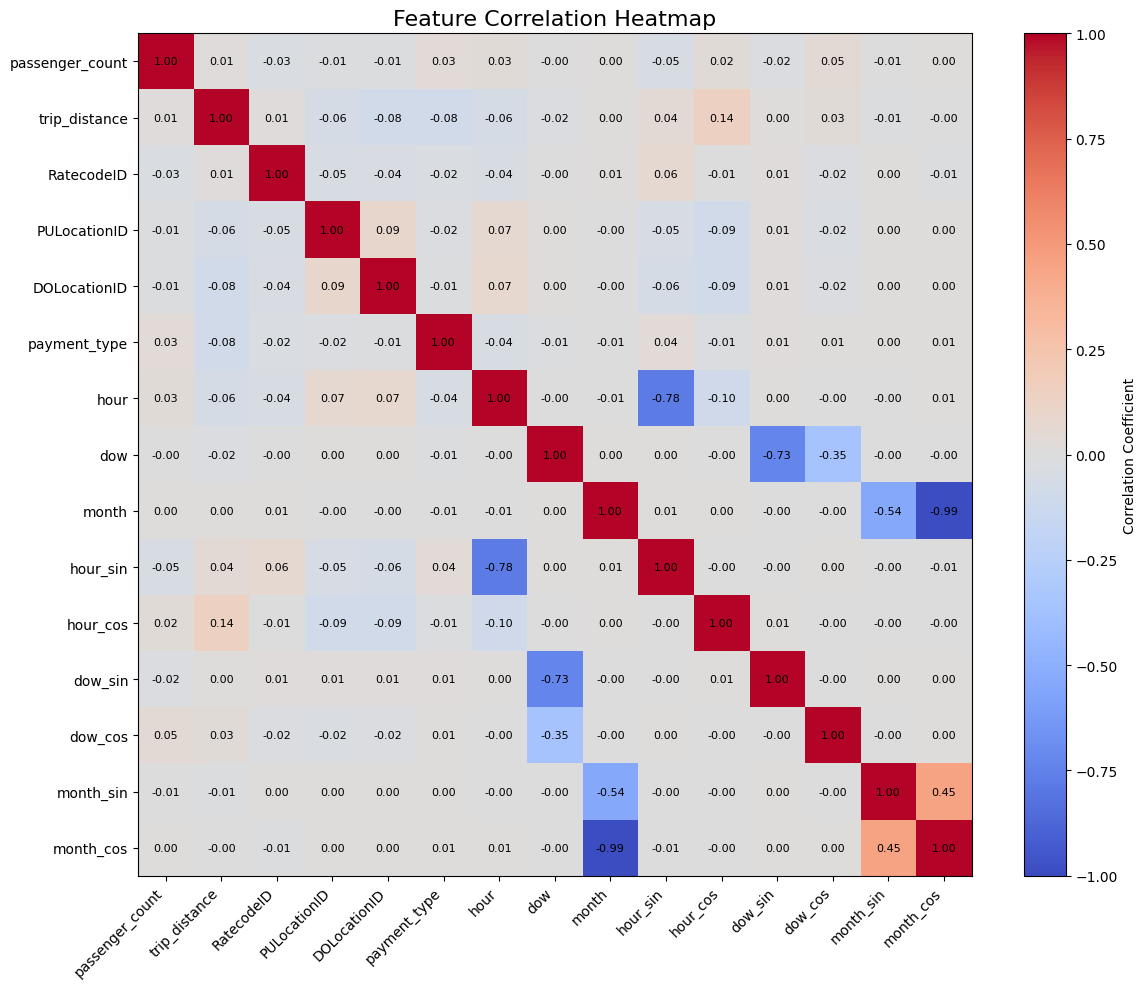

In [14]:
# Visualize correlation matrix
print("Correlation Matrix:")
print("Features:", numerical_features)

import matplotlib.pyplot as plt

# Create the heatmap
plt.figure(figsize=(12, 10))
plt.imshow(correlation_array, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')

# Add labels
plt.xticks(range(len(numerical_features)), numerical_features, rotation=45, ha='right')
plt.yticks(range(len(numerical_features)), numerical_features)

# Add correlation values as text
for i in range(len(numerical_features)):
    for j in range(len(numerical_features)):
        plt.text(j, i, f'{correlation_array[i][j]:.2f}', 
                ha='center', va='center', fontsize=8)

plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
# Define cols to drop
cols_to_drop = ["hour", "month", "day"]

# Drop from df
sample_df = sample_df.drop(*cols_to_drop)

**Observations**

Here's what we deduced from the heatmap:

* The time stuff is basically duplicating itself. The `hour` lines up tightly with `hour_sin` and `hour_cos`, same for `dow` with `dow_sin` and `dow_cos`, and `month` with `month_sin/month_cos` (some near +/-0.99).
* To avoid that redundancy, we're dropping the raw time integers and keeping the sine/cosine encodings. So, we can preserve the circular structure of time (e.g., 23:00 is close to 00:00) without the redundancy. This is important for linear and distance-based models (e.g., Linear Regression, KMeans), which would otherwise treat 23 and 0 as far apart and learn unstable, cliff-edge effects.
* Outside of those pairs, everything else barely correlates with each other, so no big multicollinearity issues to worry about.
* The zone and code columns (`PULocationID`, `DOLocationID`, `RatecodeID`, `payment_type`) don’t show meaningful Pearson correlations. This is expected since they're categorical IDs. We'll index them for the model later.

### Create location clusters using K-Means

**Strategy**

* We start by assembling the pickup location ID into a vector column using `VectorAssembler` so it can be used in Spark’s K-Means algorithm.
* The transformation step creates the pickup vector column for the model input.
* For a range of `k` values from 2 to 14, we fit K-Means models for the pickup data and record the Within Set Sum of Squared Errors (WSSSE) from each run.
* The recorded costs are plotted against their corresponding `k` values to apply the Elbow Method and choose an optimal cluster count for pickup locations.
* The same process is then repeated for drop-off location IDs. We assemble into a vector, fit models across `k` values, record WSSSE, and plot results, in order to determine the optimal cluster count for drop-off locations.
* The reason we do pickup and drop-off separately is because the spatial patterns for trip starts and ends can be different, so each requires its own optimal clustering.

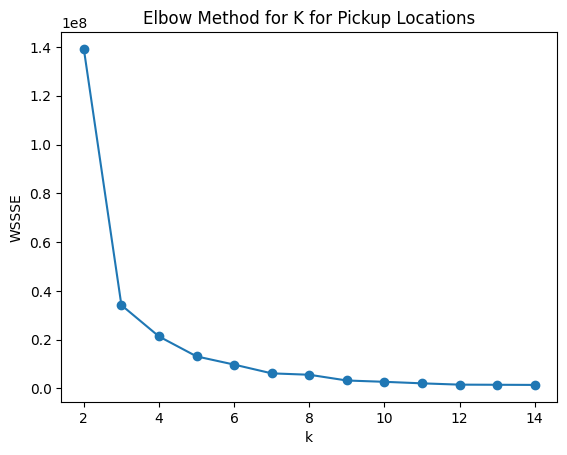

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

# Assemble location features for clustering
location_assembler = VectorAssembler(
    inputCols=["PULocationID"], 
    outputCol="pu_location_vec"
)

# Transform the sample_df to add location_features
pu_location_df = location_assembler.transform(sample_df)

# Find the best kmeans
costs = []
for k in range(2, 15):
    kmeans = KMeans(k=k, seed=42, featuresCol="pu_location_vec")
    model = kmeans.fit(pu_location_df)
    cost = model.summary.trainingCost  # WSSSE
    costs.append(cost)

plt.plot(range(2, 15), costs, marker='o')
plt.xlabel('k')
plt.ylabel('WSSSE')
plt.title('Elbow Method for K for Pickup Locations')
plt.show()

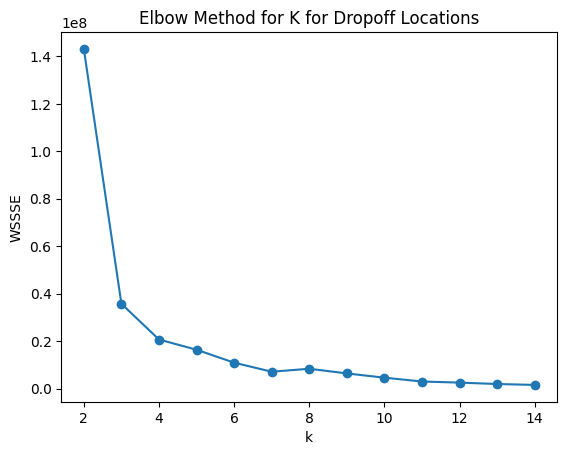

In [17]:
# Assemble location features for clustering
location_assembler = VectorAssembler(
    inputCols=["DOLocationID"], 
    outputCol="do_location_vec"
)

# Transform the sample_df to add location_features
do_location_df = location_assembler.transform(sample_df)

# Find the best kmeans
costs = []
for k in range(2, 15):
    kmeans = KMeans(k=k, seed=42, featuresCol="do_location_vec")
    model = kmeans.fit(do_location_df)
    cost = model.summary.trainingCost  # WSSSE
    costs.append(cost)

plt.plot(range(2, 15), costs, marker='o')
plt.xlabel('k')
plt.ylabel('WSSSE')
plt.title('Elbow Method for K for Dropoff Locations')
plt.show()

In [18]:
from pyspark.ml.clustering import KMeans

# Set k values for both
pickup_k = 9
dropoff_k = 9

# Create and fit pickup clusters
pu_assembler = VectorAssembler(inputCols=["PULocationID"], outputCol="pu_features")
pu_kmeans = KMeans(k=pickup_k, seed=42, featuresCol="pu_features")
pu_df = pu_assembler.transform(sample_df)
pu_model = pu_kmeans.fit(pu_df)
sample_df_with_pu = pu_model.transform(pu_df).drop("pu_features").withColumnRenamed("prediction", "pickup_cluster")

# Create and fit dropoff clusters  
do_assembler = VectorAssembler(inputCols=["DOLocationID"], outputCol="do_features")
do_kmeans = KMeans(k=dropoff_k, seed=42, featuresCol="do_features")
do_df = do_assembler.transform(sample_df_with_pu)
do_model = do_kmeans.fit(do_df)
sample_df_final = do_model.transform(do_df).drop("do_features").withColumnRenamed("prediction", "dropoff_cluster")

In [19]:
# Check if clusters were created successfully
print("Sample with clusters:")
sample_df_final.select("PULocationID", "pickup_cluster", "DOLocationID", "dropoff_cluster").show(10)

Sample with clusters:
+------------+--------------+------------+---------------+
|PULocationID|pickup_cluster|DOLocationID|dropoff_cluster|
+------------+--------------+------------+---------------+
|          79|             3|         231|              2|
|         229|             1|         137|              5|
|         263|             7|         234|              2|
|         249|             1|         107|              3|
|         239|             1|          48|              1|
|         144|             2|         158|              0|
|         161|             6|         263|              2|
|         132|             2|          10|              6|
|         100|             0|         144|              5|
|         100|             0|         261|              2|
+------------+--------------+------------+---------------+
only showing top 10 rows



In [20]:
# Check cluster distributions
print("Pickup Cluster Distribution:")
sample_df_final.groupBy("pickup_cluster").count().orderBy("pickup_cluster").show()

print("Dropoff Cluster Distribution:")
sample_df_final.groupBy("dropoff_cluster").count().orderBy("dropoff_cluster").show()

Pickup Cluster Distribution:
+--------------+-----+
|pickup_cluster|count|
+--------------+-----+
|             0| 8474|
|             1|29450|
|             2|15681|
|             3|10013|
|             4| 5542|
|             5| 7042|
|             6|17020|
|             7| 5415|
|             8| 1181|
+--------------+-----+

Dropoff Cluster Distribution:
+---------------+-----+
|dropoff_cluster|count|
+---------------+-----+
|              0|16256|
|              1| 7530|
|              2|35631|
|              3| 6189|
|              4| 8227|
|              5|15937|
|              6| 2424|
|              7| 3006|
|              8| 4618|
+---------------+-----+



In [21]:
# Analyze average fare by cluster to see if clusters capture meaningful patterns
print("Average fare and trip distance by pickup cluster:")
sample_df_final.groupBy("pickup_cluster").agg(
    F.avg("total_amount").alias("avg_fare"),
    F.avg("trip_distance").alias("avg_distance"),
    F.count("*").alias("trip_count")
).orderBy("pickup_cluster").show()

print("Average fare and trip distance by dropoff cluster:")
sample_df_final.groupBy("dropoff_cluster").agg(
    F.avg("total_amount").alias("avg_fare"),
    F.avg("trip_distance").alias("avg_distance"),
    F.count("*").alias("trip_count")
).orderBy("dropoff_cluster").show()

Average fare and trip distance by pickup cluster:
+--------------+------------------+------------------+----------+
|pickup_cluster|          avg_fare|      avg_distance|trip_count|
+--------------+------------------+------------------+----------+
|             0| 21.06711116355912| 2.060746990795374|      8474|
|             1| 20.52464991511034|1.9264960950764005|     29450|
|             2|21.831064983100568|2.1903348000765264|     15681|
|             3|21.904121641865576| 2.268336162988115|     10013|
|             4| 21.59760555756045|2.0122645254420783|      5542|
|             5| 20.53210735586481|2.0270888952002277|      7042|
|             6| 20.71480728554642| 1.870730317273795|     17020|
|             7| 22.97349215143121|2.0597525392428437|      5415|
|             8|27.256833192209992|2.6915834038950046|      1181|
+--------------+------------------+------------------+----------+

Average fare and trip distance by dropoff cluster:
+---------------+------------------+----

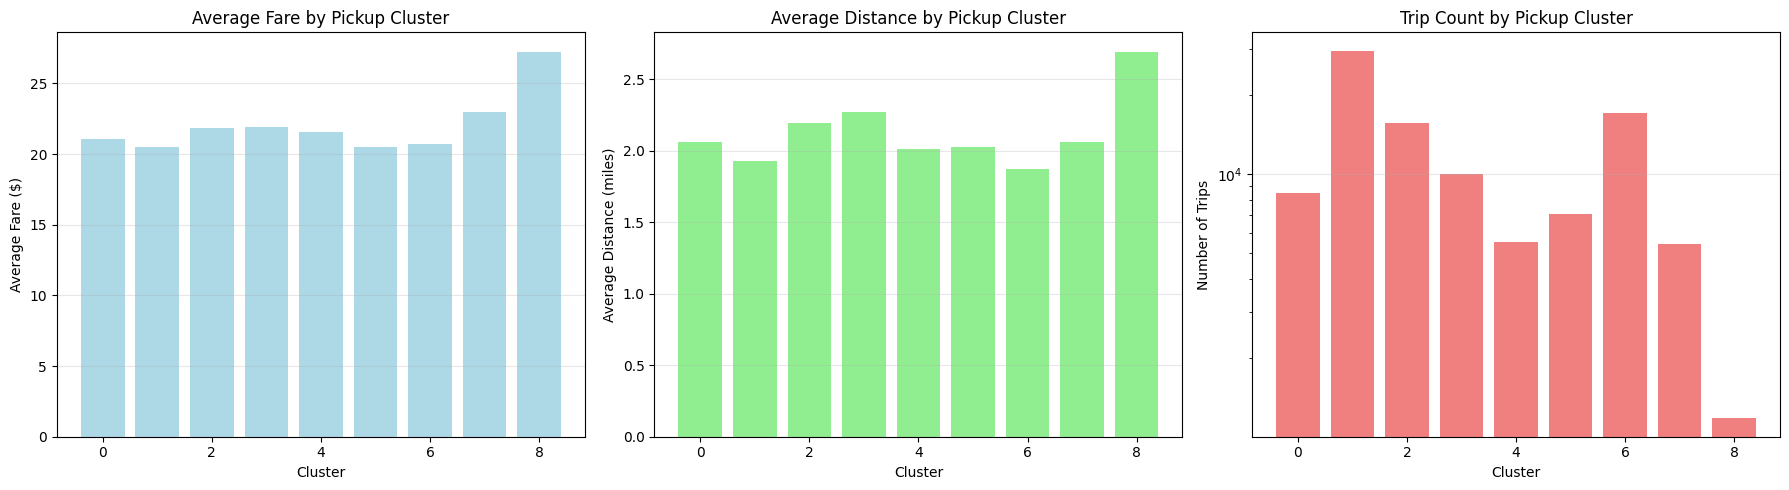

In [22]:
# Get the data for plotting
pickup_stats = sample_df_final.groupBy("pickup_cluster").agg(
    F.avg("total_amount").alias("avg_fare"),
    F.avg("trip_distance").alias("avg_distance"),
    F.count("*").alias("trip_count")
).orderBy("pickup_cluster").collect()

# Extract data for plotting
clusters = [row['pickup_cluster'] for row in pickup_stats]
avg_fares = [row['avg_fare'] for row in pickup_stats]
avg_distances = [row['avg_distance'] for row in pickup_stats]
trip_counts = [row['trip_count'] for row in pickup_stats]

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Average fare by cluster
ax1.bar(clusters, avg_fares, color='lightblue')
ax1.set_title('Average Fare by Pickup Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Average Fare ($)')
ax1.grid(axis='y', alpha=0.3)

# Average distance by cluster
ax2.bar(clusters, avg_distances, color='lightgreen')
ax2.set_title('Average Distance by Pickup Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Average Distance (miles)')
ax2.grid(axis='y', alpha=0.3)

# Trip count by cluster (log scale for better visualization)
ax3.bar(clusters, trip_counts, color='lightcoral')
ax3.set_title('Trip Count by Pickup Cluster')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Number of Trips')
ax3.set_yscale('log')
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Create advanced features

**Strategy**

* NYC taxi fares are heavily influenced by geographic and route patterns. The city has distinct pricing zones where Manhattan commands higher rates than outer boroughs. Airport routes have premium pricing, and cross-borough trips often involve tolls, bridges, or premium routes. 

* Additionally, these geographic patterns interact with time-based factors. For example, rush hour cross-cluster trips typically cost more due to traffic and surge pricing. Tree-based models can effectively learn these different fare structures by distinguishing between local neighborhood trips versus long-distance cross-city journeys.

* Based on these geographic pricing dynamics, we create cluster-based features to capture these patterns:

    * `same_cluster_trip` is the binary indicator (1/0) for trips within the same cluster. These local trips typically use minimum fare structures and avoid cross-borough surcharges.

    * `cluster_diff` is the absolute difference between pickup and dropoff cluster IDs. This captures trip complexity beyond just distance. It indicates cross-neighborhood travel patterns, potential traffic congestion routes, toll road usage, and transitions between different fare zones. For example, cluster 1 -> cluster 8 with `cluster_diff = 7` might represent a trip from a low-traffic residential area to a high-demand business district, involving premium pricing even if the actual distance is moderate.

In [23]:
# Create same cluster trip feature
sample_df_final = sample_df_final.withColumn(
    "same_cluster_trip",
    F.when(F.col("pickup_cluster") == F.col("dropoff_cluster"), 1).otherwise(0)
)

# Create cluster difference feature
sample_df_final = sample_df_final.withColumn(
    "cluster_diff",
    F.abs(F.col("pickup_cluster") - F.col("dropoff_cluster"))
)

**Strategy**

Beyond basic cluster patterns, we create additional features to capture more nuanced pricing behaviors and interactions between different trip characteristics:

* `distance_per_passenger` is to normalize trip distance by passenger count to identify shared rides vs. individual trips. Group rides often have different pricings. We hope this feature will help models distinguish between a solo 5-mile trip versus a 5-mile trip split among 3 passengers.

* `pickup_dropoff_combo` is to create unique route identifiers by combining pickup and dropoff cluster IDs. This categorical feature allows models to learn specific route pricing patterns, such as "cluster_2_to_cluster_7" consistently having higher fares due to tolls or high-cost travel routes.

* `is_premium_route` is to flag trips involving cluster 8. This cluster has the highest average fares. So by doing this, we can let models quickly identify premium routes without complex cluster arithmetic.

* `cluster_distance_interaction` multiplies pickup cluster ID by trip distance to capture how distance effects vary by starting location. For example, a 3-mile trip from a high-traffic cluster might cost more than the same distance from a residential cluster due to congestion and demand patterns.

In [24]:
# Create distance per passenger feature
sample_df_final = sample_df_final.withColumn(
    "distance_per_passenger", 
    F.col("trip_distance") / F.greatest(F.col("passenger_count"), F.lit(1))
)

# Create pickup-dropoff cluster combination
sample_df_final = sample_df_final.withColumn(
    "pickup_dropoff_combo", 
    F.concat(F.col("pickup_cluster").cast("string"), F.lit("_"), F.col("dropoff_cluster").cast("string"))
)

# Create premium route indicator
sample_df_final = sample_df_final.withColumn(
    "is_premium_route",
    F.when((F.col("pickup_cluster") == 8) | (F.col("dropoff_cluster") == 8), 1).otherwise(0)
)

# Create cluster-distance interaction
sample_df_final = sample_df_final.withColumn(
    "cluster_distance_interaction",
    F.col("pickup_cluster") * F.col("trip_distance")
)

**Strategy**

We know from common experience that hiring a cab during rush hours costs more due to higher demand and traffic congestion. Time-based pricing patterns are crucial for taxi fare prediction since demand and pricing vary significantly throughout the week and day:

* `is_rush_hour` identifies peak demand periods (weekday mornings 7-9 AM and evenings 6-9 PM) when surge pricing typically applies due to high demand and traffic congestion.

* `is_weekend` distinguishes leisure travel patterns from business travel, as weekend trips often involve different destinations, lengths, and pricing structures.

* `is_late_night` captures premium late-night pricing when fewer drivers are available and safety premiums may apply.

In [25]:
# Create time-based features
sample_df_final = sample_df_final.withColumn(
    "is_rush_hour",
    F.when((F.col("dow") >= 1) & (F.col("dow") <= 5) & 
           ((F.col("hour_sin") > 0.7) | (F.col("hour_sin") < -0.7)), 1).otherwise(0)
).withColumn(
    "is_weekend", 
    F.when((F.col("dow") == 6) | (F.col("dow") == 0), 1).otherwise(0)
).withColumn(
    "is_late_night",
    F.when((F.col("hour_sin") < -0.9) | (F.col("hour_sin") > 0.9), 1).otherwise(0)
)

**Strategy**

Payment methods and rate codes in NYC taxi trips carry significant predictive power for fare amounts due to their connection to different pricing structures and trip types:

* `is_cash_payment` identifies cash transactions (payment_type == 2) versus credit card payments. Cash payments may correlate with different tipping behaviors, fare negotiation patterns, or specific demographic preferences that affect total amounts.

* `is_airport_rate` flags trips using the airport rate code (RatecodeID == 2), which typically involves premium flat-rate pricing for trips to/from airports like JFK, LaGuardia, and Newark. These trips often have higher base fares and different fare structures compared to standard meter rates.

* `is_standard_rate` identifies standard metered trips (RatecodeID == 1), representing the most common fare calculation method based on time and distance. This helps models distinguish between different pricing mechanisms.

In [26]:
# Create payment behavior features  
sample_df_final = sample_df_final.withColumn(
    "is_cash_payment",
    F.when(F.col("payment_type") == 2, 1).otherwise(0)
).withColumn(
    "is_airport_rate", 
    F.when(F.col("RatecodeID") == 2, 1).otherwise(0)
).withColumn(
    "is_standard_rate",
    F.when(F.col("RatecodeID") == 1, 1).otherwise(0)
)

**Strategy**

To capture complex pricing behaviors that emerge from feature interactions, we create combination features that help models learn non-linear relationships:

* `weekend_premium_route` combines weekend travel with premium routes (cluster 8). Weekend trips to high-fare areas like airports or Manhattan may have different pricing patterns than weekday business travel.

* `rush_hour_distance` multiplies rush hour indicator by trip distance. This captures how distance costs escalate during peak traffic times when longer trips face more congestion and higher per-mile rates.

* `cluster_passenger_interaction` combines pickup cluster with passenger count. This helps identify how group size affects pricing in different neighborhoods - for example, shared rides from high-traffic areas versus individual trips from residential zones.

In [27]:
# Create time-location interaction features
sample_df_final = sample_df_final.withColumn(
    "weekend_premium_route",
    F.col("is_weekend") * F.col("is_premium_route")
)

# Create time-distance interaction features  
sample_df_final = sample_df_final.withColumn(
    "rush_hour_distance",
    F.col("is_rush_hour") * F.col("trip_distance")
)

# Create cluster-passenger interaction features
sample_df_final = sample_df_final.withColumn(
    "cluster_passenger_interaction", 
    F.col("pickup_cluster") * F.col("passenger_count")
)

In [28]:
# Verify the final schema
print("Final DataFrame Schema:")
sample_df_final.printSchema()

Final DataFrame Schema:
root
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- dow: integer (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- dow_sin: double (nullable = true)
 |-- dow_cos: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)
 |-- pickup_cluster: integer (nullable = false)
 |-- dropoff_cluster: integer (nullable = false)
 |-- same_cluster_trip: integer (nullable = false)
 |-- cluster_diff: integer (nullable = false)
 |-- distance_per_passenger: double (nullable = true)
 |-- pickup_dropoff_combo: string (nullable = false)
 |-- is_premium_route: integer 

In [29]:
len(sample_df_final.columns)

32

**Observations**

Now that we have engineered all these advanced features, our final dataset contains 32 columns including:

* Original features: Basic trip details like `passenger_count`, `trip_distance`, location IDs, and payment information
* Time encodings: Cyclical transformations (`hour_sin/cos`, `dow_sin/cos`, `month_sin/cos`) that preserve temporal relationships
* Cluster features: Location groupings (`pickup_cluster`, `dropoff_cluster`) and derived metrics (`same_cluster_trip`, `cluster_diff`)
* Interaction features: Complex combinations like `weekend_premium_route`, `rush_hour_distance`, and `cluster_distance_interaction`
* Business logic flags: Binary indicators for pricing patterns (`is_premium_route`, `is_cash_payment`, `is_airport_rate`)

With this rich feature set capturing geographic, temporal, and behavioral patterns in NYC taxi pricing, we still need to check for multicollinearity among all engineered features. 

New feature interactions can create unexpected correlations that weren't present in the original data, potentially causing model instability or redundant information that could hurt performance.

### Check multicollinearity for all engineered features

**Strategy**

* We first select all numerical columns except the target variable and store them in a list.
* These features go into a single vector column using `VectorAssembler` for correlation analysis in Spark.
* We run `Correlation.corr()` to compute the Pearson correlation matrix and convert the result to a NumPy array for easy inspection.
* A nested loop goes through the matrix to find feature pairs with an absolute correlation above 0.8.
* The result shows that `trip_distance` and `distance_per_passenger` have a strong correlation of 0.904.

In [30]:
# Get all numerical columns except target
numerical_features = [
    field.name for field in sample_df_final.schema.fields 
    if field.dataType.typeName() in ['double', 'integer', 'long', 'float'] 
    and field.name != 'total_amount'
]

print(f"Found {len(numerical_features)} numerical cols")

Found 29 numerical cols


In [31]:
# Create correlation analysis
corr_assembler = VectorAssembler(inputCols=numerical_features, outputCol="features_corr")
corr_df = corr_assembler.transform(sample_df_final)
correlation_matrix = Correlation.corr(corr_df, "features_corr").head()
correlation_array = correlation_matrix[0].toArray()

# Find high correlations automatically
print("High correlations found (>0.8 or <-0.8):")
high_corr_pairs = []
for i in range(len(numerical_features)):
    for j in range(i+1, len(numerical_features)):
        corr_val = correlation_array[i][j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((numerical_features[i], numerical_features[j], corr_val))
            print(f"{numerical_features[i]} <-> {numerical_features[j]}: {corr_val:.3f}")

High correlations found (>0.8 or <-0.8):
trip_distance <-> distance_per_passenger: 0.904


**Observations**

* We found a high correlation between `trip_distance` and `distance_per_passenger` (0.904). 

* This makes sense because distance_per_passenger is trip_distance / passenger_count.

* When most trips have 1 passenger, distance_per_passenger become trip_distance.

* So, we have to check if more than 80% of trips in sample data are single passenger. 

* If >80%, we will drop that column due to redundancy. Else, we will keep distance_per_passenger since it can add value for group rides.

### Check passenger_count distribution

**Strategy**

* We group the dataset by `passenger_count` and count the records for each value, ordering the output by passenger count.
* We filter rows where `passenger_count` equals 1, count them, and divide by the total number of trips to find the share of single-passenger trips.

In [32]:
# Check if distance_per_passenger adds unique information
print("Checking passenger count distribution:")
sample_df_final.groupBy("passenger_count").count().orderBy("passenger_count").show()

# Check the percentage of single passenger trips
passenger_1_ratio = sample_df_final.filter(F.col("passenger_count") == 1).count() / sample_df_final.count()
print(f"Single passenger trips: {passenger_1_ratio:.1%}")

Checking passenger count distribution:
+---------------+-----+
|passenger_count|count|
+---------------+-----+
|            0.0| 1671|
|            1.0|77710|
|            2.0|13259|
|            3.0| 3289|
|            4.0| 1678|
|            5.0| 1397|
|            6.0|  814|
+---------------+-----+

Single passenger trips: 77.9%


**Observations**

* The result shows that 1 passenger trips make up about 77.9% of the dataset. 

* However, the remaining 22.1% multi-passenger trips still represent a significant portion (~22K trips in our sample).

* That's why we decided to keep this column because:
  * 22k rows are not negligible for model learning.
  * Group rides can have different pricing patterns.
  * Tree-based models can handle correlated features and find useful splits.

### Check distributions of nerumic columns

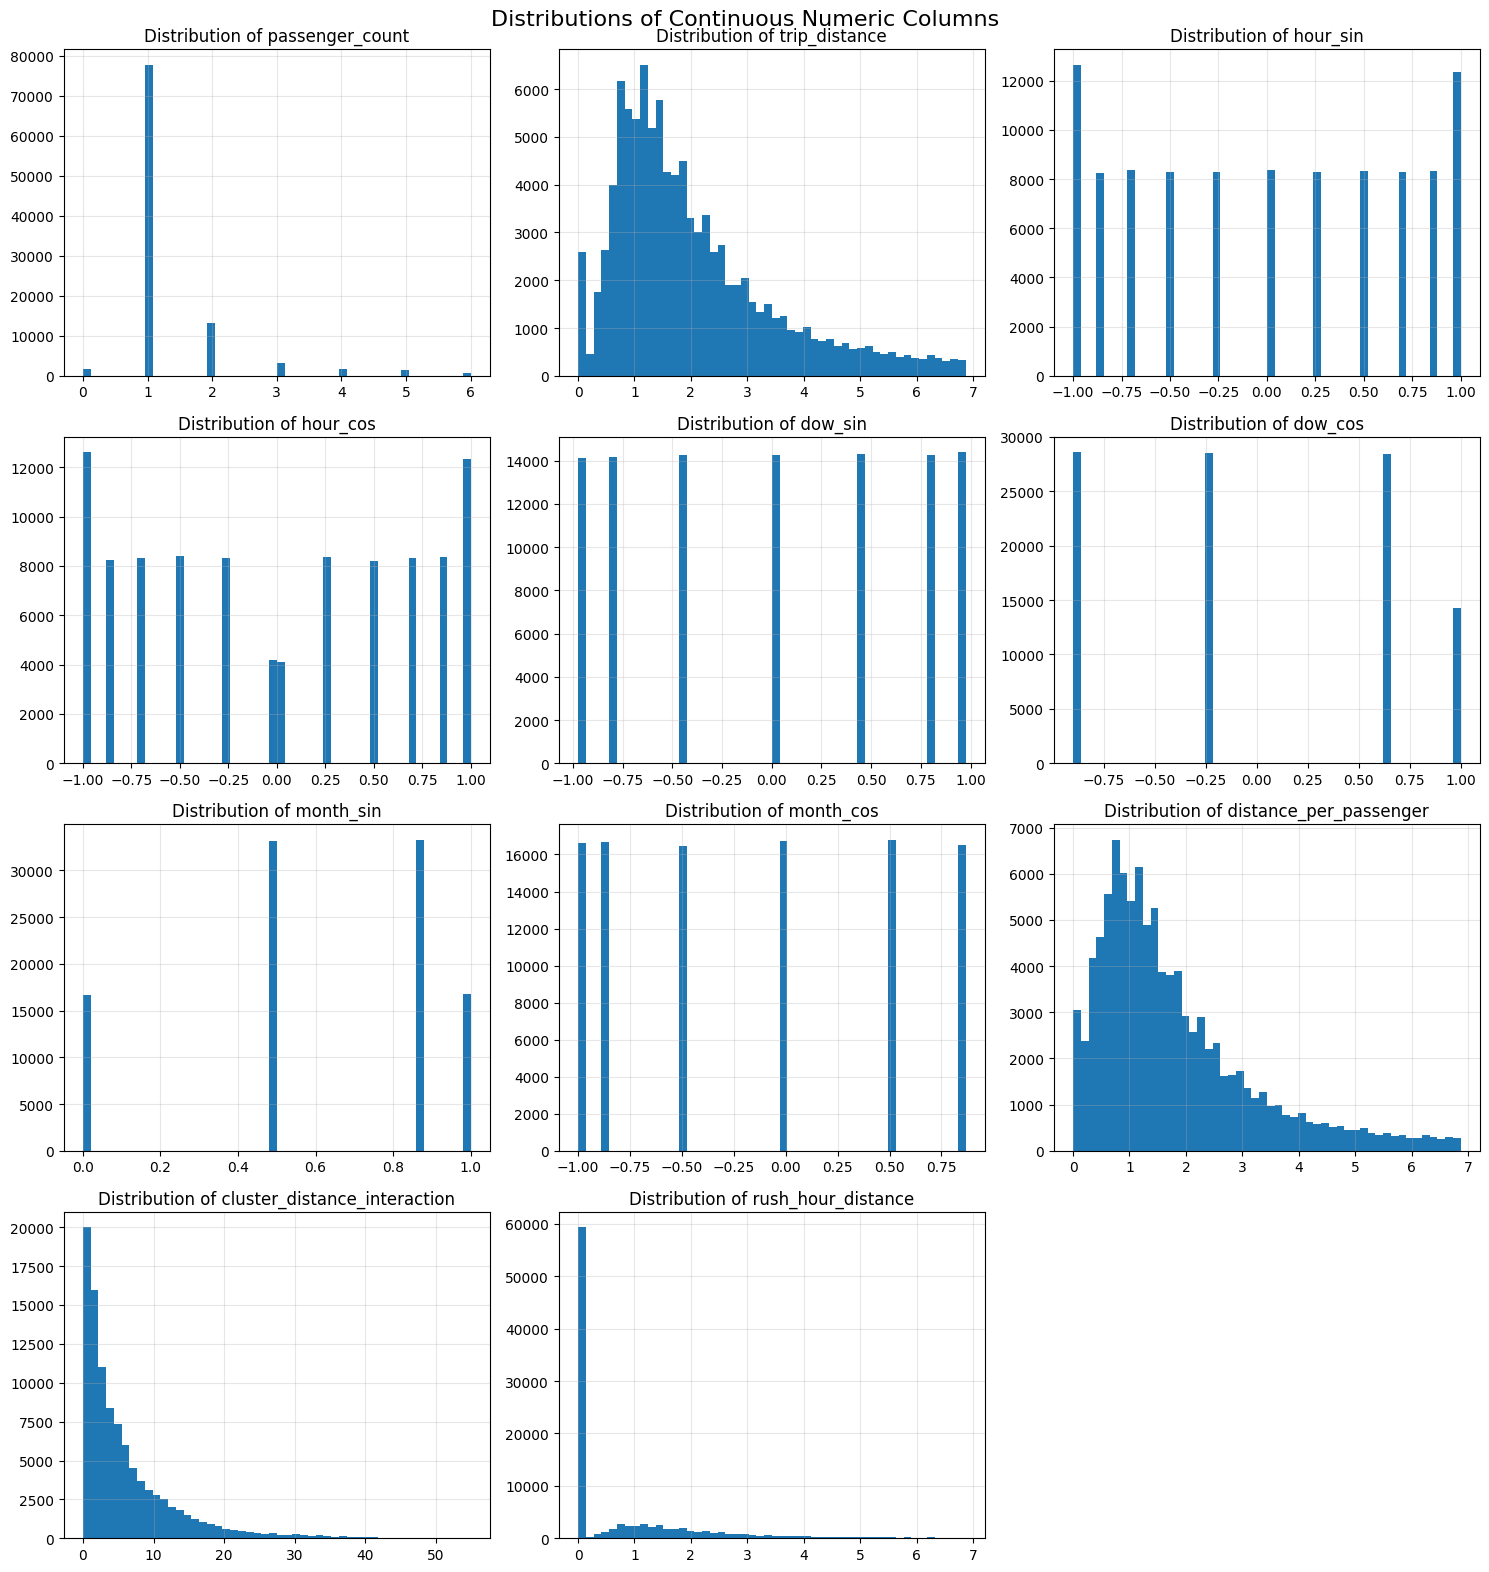

In [33]:
import math

numeric_cols_continuous = [
    "passenger_count", 
    "trip_distance",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "month_sin", "month_cos",
    "distance_per_passenger",
    "cluster_distance_interaction",
    "rush_hour_distance"
]

# Convert to Pandas
pdf = sample_df_final.select(numeric_cols_continuous).toPandas()

# Plot histograms in a grid
rows = math.ceil(len(numeric_cols_continuous) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 4))
fig.suptitle("Distributions of Continuous Numeric Columns", fontsize=16)

axes = axes.flatten()

for i, col in enumerate(numeric_cols_continuous):
    axes[i].hist(pdf[col].dropna(), bins=50)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].grid(True, alpha=0.3)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Observations**

* We see that most trips have exactly 1 passenger, with a smaller number showing 2 or more. There are also trips with 0 passengers, which we suspect are data entry issues or placeholder defaults.
* For trip distance, the distribution is heavily right-skewed. Most trips are short (under 3 miles), but there is a long tail of long-distance trips.
* The cyclical encoding features for hour, day of week, and month (`*_sin` / `*_cos`) have discrete, evenly spaced values as expected, since they come from transforming categorical time features into a sinusoidal space.
* Distance per passenger follows a similar skew to trip distance, with larger values linked to long trips carrying few passengers.
* Cluster distance interaction is extremely right-skewed. Most trips fall into low interaction values, but a small number are much higher, likely long trips crossing multiple clusters.
* Rush hour distance is concentrated near zero, meaning many trips are either short or outside rush hours. A small set of trips show high values, representing long rush-hour journeys.

### Check cardinality of categorical features

In [34]:
# Define categorical features
categorical_features = [
    # Original categorical features
    "store_and_fwd_flag", "RatecodeID", "payment_type", "PULocationID", "DOLocationID",

    # Engineered categorical feature
    "pickup_dropoff_combo"
]

# Check unique value counts
for col in categorical_features:
    if col in sample_df_final.columns:
        cardinality = sample_df_final.select(col).distinct().count()
        print(f"{col}: {cardinality} unique values")
    else:
        print(f"{col}: Column not found")

store_and_fwd_flag: 3 unique values
RatecodeID: 6 unique values
payment_type: 5 unique values
PULocationID: 220 unique values
DOLocationID: 231 unique values
pickup_dropoff_combo: 81 unique values


### Check variance of continous numeric columns

In [35]:
from pyspark.sql import functions as F

variance_df = sample_df_final.select([
    F.variance(F.col(c)).alias(c) for c in numeric_cols_continuous
])
variance_df.show(truncate=False)

+------------------+------------------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+----------------------+----------------------------+------------------+
|passenger_count   |trip_distance     |hour_sin         |hour_cos           |dow_sin            |dow_cos           |month_sin          |month_cos          |distance_per_passenger|cluster_distance_interaction|rush_hour_distance|
+------------------+------------------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+----------------------+----------------------------+------------------+
|0.7521146992590784|2.0669483536490016|0.500310366092323|0.49968763968934105|0.49961270316439227|0.5003856513436781|0.11324741202932151|0.47146819020030706|1.9606238240535567    |49.98355185331539           |1.7429402151704512|
+------------------+------------------+-----------------+-------------------+-----------

**Observations**

* We usually only drop features with variance below 0.1 since they have almost no spread. 

* Here, only `month_sin` has low value of 0.11. But still it is slightly above that cutoff, so we wouldn’t drop it solely on variance.

* `cluster_distance_interaction` has the highest variance in the set, which is expected because it can take on large values when long trips span clusters far apart.

* `rush_hour_distance` also shows substantial variance, reflecting a mix of very short and some long trips during rush hours.

* The cyclical features for hour (`hour_sin`, `hour_cos`) and day of week (`dow_sin`, `dow_cos`) have balanced variances around 0.5, which is expected since they range between -1 and 1 and are evenly distributed across their cycles.

* `month_cos` has higher variance than `month_sin`, which may mean trips are not evenly spread across the year, leading to an imbalance in the sine component while the cosine component captures more variation.

* `passenger_count` has moderate variance, which reflects that most trips have 1 passenger but there's still some spread from other passenger counts.

## Model Training

### Define Feature Engineering Pipeline

**Strategy**

* Now that all our features are ready, we need to handle our categorical features properly before we can feed them into our models. We've got a mix of different categorical variables with very different cardinalities, so we can't just use one approach for everything.

* Looking at our categorical features, we've got three low-cardinality ones (`store_and_fwd_flag`, `RatecodeID`, `payment_type`) that have just <7 unique values each. For these, we're going with the `StringIndexer` + `OneHotEncoder` combo.

    * First, we create StringIndexers for each of these columns. The StringIndexer converts our string categories into numeric indices (like 0, 1, 2, etc.). We're using `handleInvalid="keep"` so if we encounter any new categories during prediction that weren't in our training data, it won't crash - it'll just assign them a special index.
    * Then we use OneHotEncoder to turn those numeric indices into proper binary vectors. So instead of having `payment_type = 1`, we get separate binary columns like `payment_type_vec = [0, 1, 0]`. We set `dropLast=True` to avoid the dummy variable trap - basically preventing multicollinearity by dropping one of the binary columns.

* Now for our high-cardinality categorical (`pickup_dropoff_combo`), we can't use one-hot encoding because it would explode our feature space. This thing has 81 unique route combinations. If we one-hot encoded it, we'd get 81 new columns, which is way too much.

* Instead, we use `FeatureHasher` to map all those route combinations into a fixed-size vector space of 1000 features. It uses hash functions to distribute the categories across this space, so we keep most of the information but in a much more manageable form.

In [36]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, FeatureHasher, StandardScaler

# Define low-cardinality cat cols
low_card_cols = ["store_and_fwd_flag", "RatecodeID", "payment_type"]

# Create StringIndexers for categorical columns 
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in low_card_cols
]

# Create OneHotEncoder to convert indexed categories to binary vectors
ohe = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in low_card_cols],
    outputCols=[f"{c}_vec" for c in low_card_cols],
    dropLast=True
)

# Define high-cardinality cat cols
high_card_cols = ["pickup_dropoff_combo"]

# Create FeatureHasher for high-cardinality cat col
hasher = FeatureHasher(
    inputCols=high_card_cols,
    outputCol="cluster_combo_hashed",
    numFeatures=1000
)

**Strategy**

* Now we need to put all our features together into one big vector that our models can actually use. Our `numeric_cols` list includes the basics like `passenger_count` and `trip_distance`, plus all the time encodings we created (`hour_sin/cos`, `dow_sin/cos`, `month_sin/cos`), our cluster features, and all those interaction terms we built to capture complex pricing patterns.

* The `VectorAssembler` is going to combine three types of features:
    * All our numerical columns (24 of them)
    * The one-hot encoded categorical vectors from our low-cardinality features 
    * The hashed representation of our high-cardinality `pickup_dropoff_combo`

* We're calling the output `raw_features` because we still need to scale everything. Different features have wildly different ranges - trip distance might be 0-20 miles while our interaction terms could be much larger numbers.

* That's where `StandardScaler` comes in. We're using both `withMean=True` and `withStd=True` to center everything around zero and scale to unit variance. This is crucial for Linear Regression to work properly and helps all our models converge better during training.

* The final `features` column will be what we actually feed into our models, a nicely scaled, properly formatted feature vector ready for machine learning.

In [37]:
# Assemble all numerical and engineered features
numeric_cols = [
    "passenger_count", "trip_distance",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
    "pickup_cluster", "dropoff_cluster", "same_cluster_trip", "cluster_diff",
    "distance_per_passenger", "is_premium_route", "cluster_distance_interaction",
    "is_rush_hour", "is_weekend", "is_late_night",
    "is_cash_payment", "is_airport_rate", "is_standard_rate",
    "weekend_premium_route", "rush_hour_distance", "cluster_passenger_interaction"
]

# Define VectorAssembler with correct variable names
assembler = VectorAssembler(
    inputCols=(
        numeric_cols
        + [f"{c}_vec" for c in low_card_cols]  # outputs from ohe
        + ["cluster_combo_hashed"] # output from hasher
    ),
    outputCol="raw_features"
)

# Define StandardScaler for scaling
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withMean=True,
    withStd=True
)

### Split Data into Training and Test sets

In [38]:
# Split the dataset with all engineered features
train_data, test_data = sample_df_final.randomSplit([0.8, 0.2], seed=42)

# Set target column
target_col = "total_amount"

# Show dataset sizes
print(f"Training data count: {train_data.count()}")
print(f"Test data count: {test_data.count()}")

Training data count: 79897
Test data count: 19921


In [39]:
from pyspark.ml import Pipeline

# Create complete feature engineering pipeline and apply it
feature_pipeline = Pipeline(stages=indexers + [ohe, hasher, assembler, scaler])

# Fit the pipeline on training data
fitted_pipeline = feature_pipeline.fit(train_data)

# Transform both training and test data
train_features = fitted_pipeline.transform(train_data)
test_features = fitted_pipeline.transform(test_data)

# Verify the features column was created
print("Training features schema:")
train_features.select("features").printSchema()
print(f"Feature vector size: {len(train_features.select('features').first()[0])}")

Training features schema:
root
 |-- features: vector (nullable = true)

Feature vector size: 1038


### Initialize and Configure Models

In [40]:
# Define models
lr = LinearRegression(featuresCol="features", labelCol=target_col)
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, maxDepth=10)
dt = DecisionTreeRegressor(featuresCol="features", labelCol=target_col)
gbt = GBTRegressor(featuresCol="features", labelCol=target_col)

# Add distance-based model using Generalized Linear Regression with appropriate family
glr = GeneralizedLinearRegression(
    featuresCol="features", 
    labelCol=target_col,
    family="gaussian",  # For continuous target
    link="identity",    # Linear relationship
    maxIter=100
)

In [41]:
# Create pipeline for each model
baseline_models = {
    "LinearRegression": lr,
    "RandomForestRegressor": rf, 
    "DecisionTreeRegressor": dt,
    "GBTRegressor": gbt,
    "GeneralizedLinearRegression": glr,
}

### Train each model

In [42]:
def train_models(models_dict, train_data):
    """
    Trains each model in the dictionary on the provided training data.

    Args:
        models_dict (dict): Dictionary of model_name and untrained model/pipeline.
        train_data (DataFrame): Training dataset.

    Returns:
        trained_models (dict): Dictionary mapping model names to trained models.
    """
    # Initialize trained_models
    trained_models = {}

    # Train each model
    for model_name, model in models_dict.items():
        print(f"Training {model_name}...")
        
        # Train the model
        trained_model = model.fit(train_data)

        # Add to trained_models dict
        trained_models[model_name] = trained_model

        # Print confirmation
        print(f"{model_name} trained successfully!")

    return trained_models

In [43]:
# Train models using transformed data (train_features)
trained_models = train_models(baseline_models, train_features)

Training LinearRegression...
LinearRegression trained successfully!
Training RandomForestRegressor...
RandomForestRegressor trained successfully!
Training DecisionTreeRegressor...
DecisionTreeRegressor trained successfully!
Training GBTRegressor...
GBTRegressor trained successfully!
Training GeneralizedLinearRegression...
GeneralizedLinearRegression trained successfully!


## Model Evaluation

### Initialize Evaluators and Predictions

In [44]:
# Initialize evaluators
rmse_evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol=target_col, metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol=target_col, metricName="r2")

### Evaluate Baseline Models

In [45]:
def evaluate_models(trained_models, test_data, rmse_evaluator, mae_evaluator, r2_evaluator):
    """
    Predict and evaluate each trained model on the given test data.

    Args:
        trained_models (dict): Dictionary of trained models with model names as keys.
        test_data (DataFrame): Spark DataFrame to make predictions on.
        rmse_evaluator (RegressionEvaluator): Evaluator for computing RMSE.
        mae_evaluator (RegressionEvaluator): Evaluator for computing MAE.
        r2_evaluator (RegressionEvaluator): Evaluator for computing R².

    Returns:
        model_predictions (dict): Dictionary of model predictions keyed by model name.
        results (list): List of tuples containing (model_name, rmse, mae, r2).
    """
    # Initialize predictions dictionary
    model_predictions = {}
    # Initialize results list
    results = []

    # Predict and evaluate each trained model
    for model_name, model in trained_models.items():
        print(f"Evaluating {model_name}...")
        
        # Make predictions and save to dict
        predictions = model.transform(test_data)
        model_predictions[model_name] = predictions

        # Compute evaluation metrics: RMSE, MAE, R²
        rmse = rmse_evaluator.evaluate(predictions)
        mae = mae_evaluator.evaluate(predictions)
        r2 = r2_evaluator.evaluate(predictions)
        
        results.append((model_name, rmse, mae, r2))

        # Print each result
        print(f"{model_name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}\n")

    return model_predictions, results

In [46]:
# Evaluate on test data using trained_models
print("Evaluate Baseline Models on Test Set")
baseline_predictions, baseline_results = evaluate_models(
    trained_models,
    test_features,
    rmse_evaluator,
    mae_evaluator,
    r2_evaluator
)

Evaluate Baseline Models on Test Set
Evaluating LinearRegression...
LinearRegression: RMSE=5.849, MAE=2.832, R²=0.681

Evaluating RandomForestRegressor...
RandomForestRegressor: RMSE=5.438, MAE=2.596, R²=0.725

Evaluating DecisionTreeRegressor...
DecisionTreeRegressor: RMSE=6.173, MAE=3.199, R²=0.645

Evaluating GBTRegressor...
GBTRegressor: RMSE=5.628, MAE=2.650, R²=0.705

Evaluating GeneralizedLinearRegression...
GeneralizedLinearRegression: RMSE=5.849, MAE=2.832, R²=0.681



### Create comprehensive visualizations for all models 

In [47]:
# View the raw results
print("Baseline Results:")
for model_name, rmse, mae, r2 in baseline_results:
    print(f"{model_name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

Baseline Results:
LinearRegression: RMSE=5.849, MAE=2.832, R²=0.681
RandomForestRegressor: RMSE=5.438, MAE=2.596, R²=0.725
DecisionTreeRegressor: RMSE=6.173, MAE=3.199, R²=0.645
GBTRegressor: RMSE=5.628, MAE=2.650, R²=0.705
GeneralizedLinearRegression: RMSE=5.849, MAE=2.832, R²=0.681


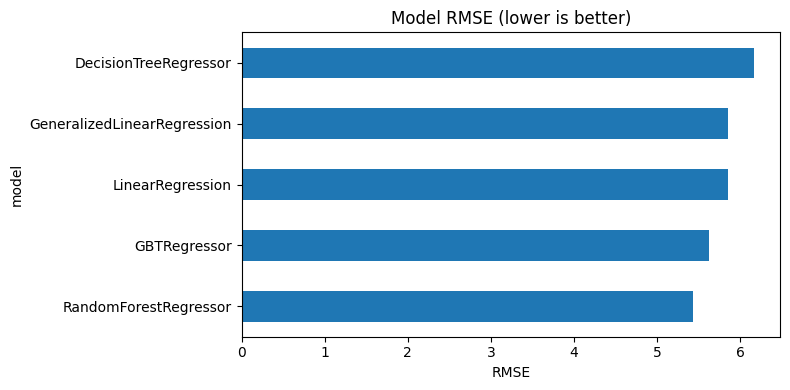

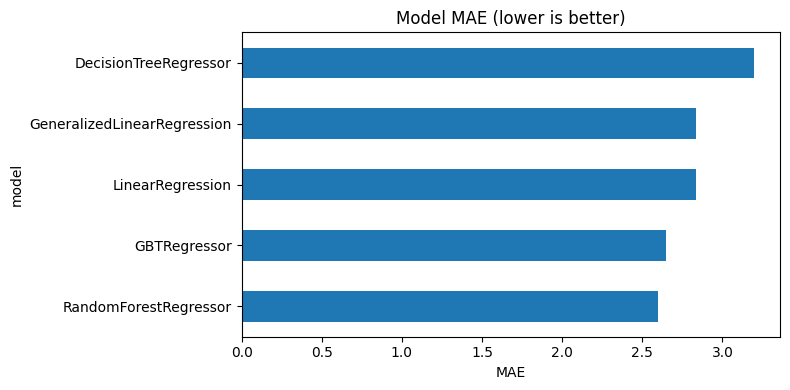

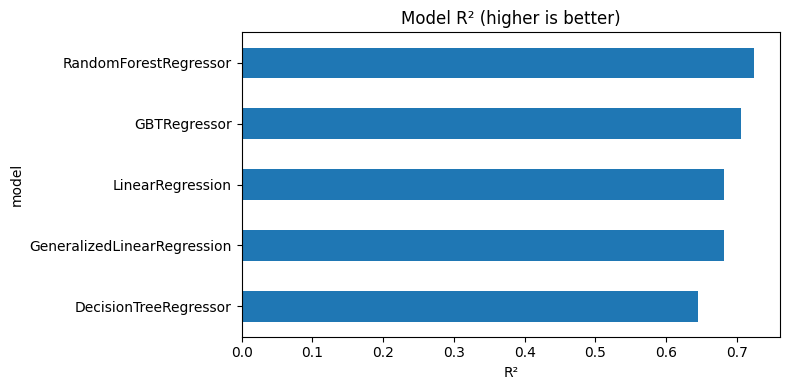

In [48]:
import pandas as pd

# Convert to DataFrame
metrics_df = pd.DataFrame(baseline_results, columns=["model", "rmse", "mae", "r2"]).set_index("model")

# RMSE plot
plt.figure(figsize=(8, 4))
metrics_df["rmse"].sort_values().plot(kind="barh")
plt.xlabel("RMSE")
plt.title("Model RMSE (lower is better)")
plt.tight_layout()
plt.show()

# MAE plot
plt.figure(figsize=(8, 4))
metrics_df["mae"].sort_values().plot(kind="barh")
plt.xlabel("MAE")
plt.title("Model MAE (lower is better)")
plt.tight_layout()
plt.show()

# R² plot
plt.figure(figsize=(8, 4))
metrics_df["r2"].sort_values().plot(kind="barh")
plt.xlabel("R²")
plt.title("Model R² (higher is better)")
plt.tight_layout()
plt.show()

### Visualize actual vs predicted plots for each model

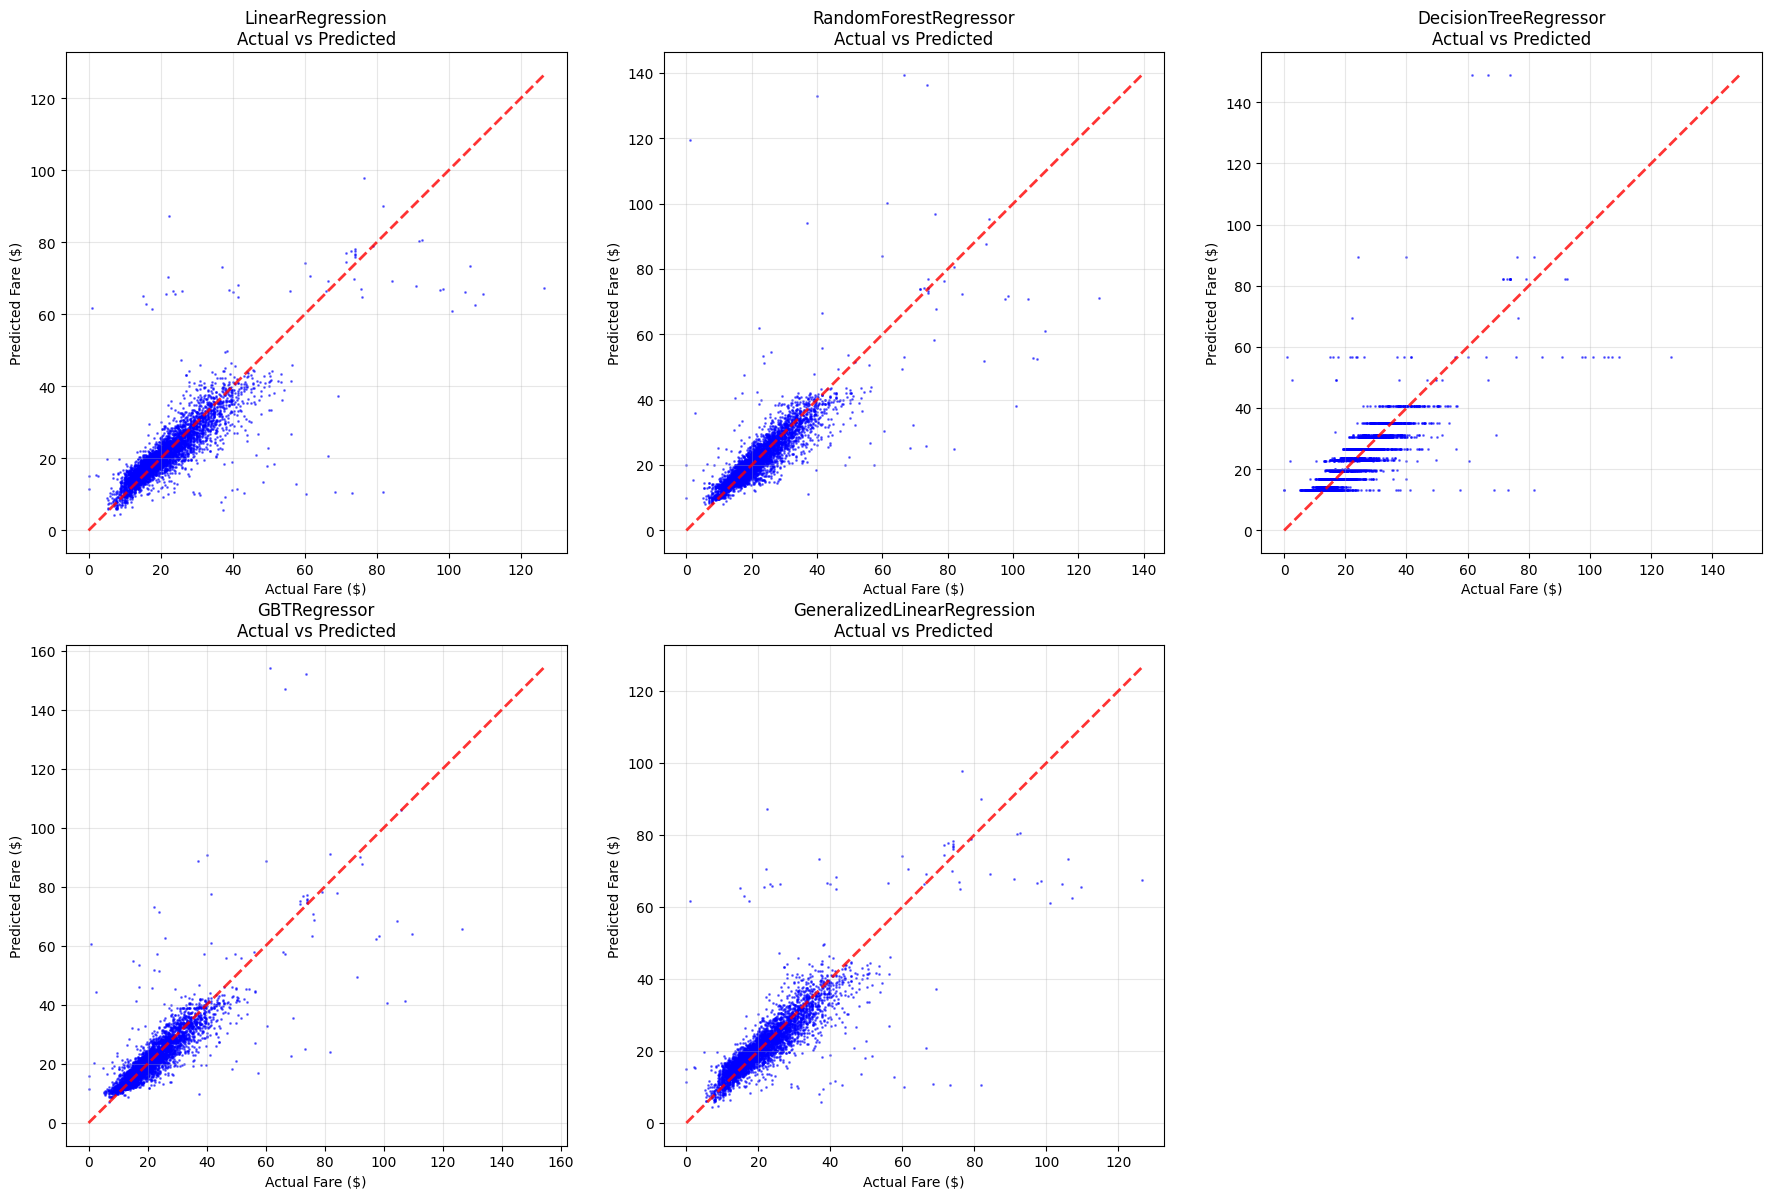

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Create actual vs predicted plots for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, predictions_df) in enumerate(baseline_predictions.items()):
    # Convert Spark DataFrame to Pandas for plotting
    plot_data = predictions_df.select('total_amount', 'prediction').toPandas()
    
    # Sample data for better visualization (if too many points)
    if len(plot_data) > 5000:
        plot_data = plot_data.sample(n=5000, random_state=42)
    
    # Create scatter plot
    axes[idx].scatter(plot_data['total_amount'], plot_data['prediction'], 
                     alpha=0.5, s=1, color='blue')
    
    # Add perfect prediction line (y=x)
    min_val = min(plot_data['total_amount'].min(), plot_data['prediction'].min())
    max_val = max(plot_data['total_amount'].max(), plot_data['prediction'].max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
    
    # Set labels and title
    axes[idx].set_xlabel('Actual Fare ($)')
    axes[idx].set_ylabel('Predicted Fare ($)')
    axes[idx].set_title(f'{model_name}\nActual vs Predicted')
    axes[idx].grid(True, alpha=0.3)
    
    # Set equal aspect ratio
    axes[idx].set_aspect('equal', adjustable='box')

# Hide the last subplot if we have fewer than 6 models
if len(baseline_predictions) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

### Visualize feature importance analysis for tree-based models

Features 0-23: Numeric features
Features 24-33: One-hot encoded categorical
Features 34+: Hashed route combinations

=== RandomForestRegressor Top Features ===
 1. trip_distance             (  1): 0.2024
 2. distance_per_passenger    ( 12): 0.1952
 3. hashed_route_27           ( 27): 0.1127
 4. is_standard_rate          ( 20): 0.0991
 5. hashed_route_28           ( 28): 0.0351
 6. cluster_distance_interaction ( 14): 0.0307
 7. hour_cos                  (  3): 0.0297
 8. hour_sin                  (  2): 0.0295
 9. hashed_route_29           ( 29): 0.0244
10. rush_hour_distance        ( 22): 0.0238
11. hashed_route_33           ( 33): 0.0185
12. is_airport_rate           ( 19): 0.0178
13. passenger_count           (  0): 0.0177
14. hashed_route_689          (689): 0.0166
15. hashed_route_30           ( 30): 0.0160


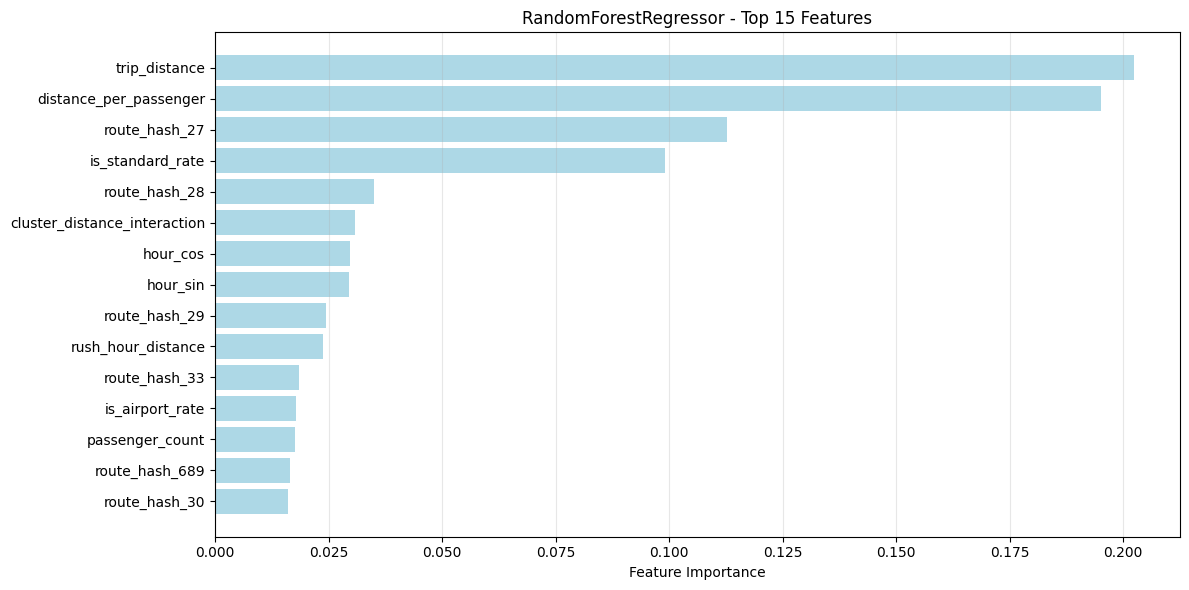


=== DecisionTreeRegressor Top Features ===
 1. trip_distance             (  1): 0.5301
 2. is_standard_rate          ( 20): 0.3052
 3. hashed_route_29           ( 29): 0.0518
 4. hashed_route_689          (689): 0.0304
 5. is_airport_rate           ( 19): 0.0237
 6. hashed_route_33           ( 33): 0.0199
 7. hour_cos                  (  3): 0.0139
 8. hashed_route_28           ( 28): 0.0132
 9. RatecodeID_encoded        ( 25): 0.0050
10. is_cash_payment           ( 18): 0.0028
11. cluster_diff              ( 11): 0.0016
12. hour_sin                  (  2): 0.0014
13. distance_per_passenger    ( 12): 0.0008
14. hashed_route_120          (120): 0.0002
15. dropoff_cluster           (  9): 0.0001


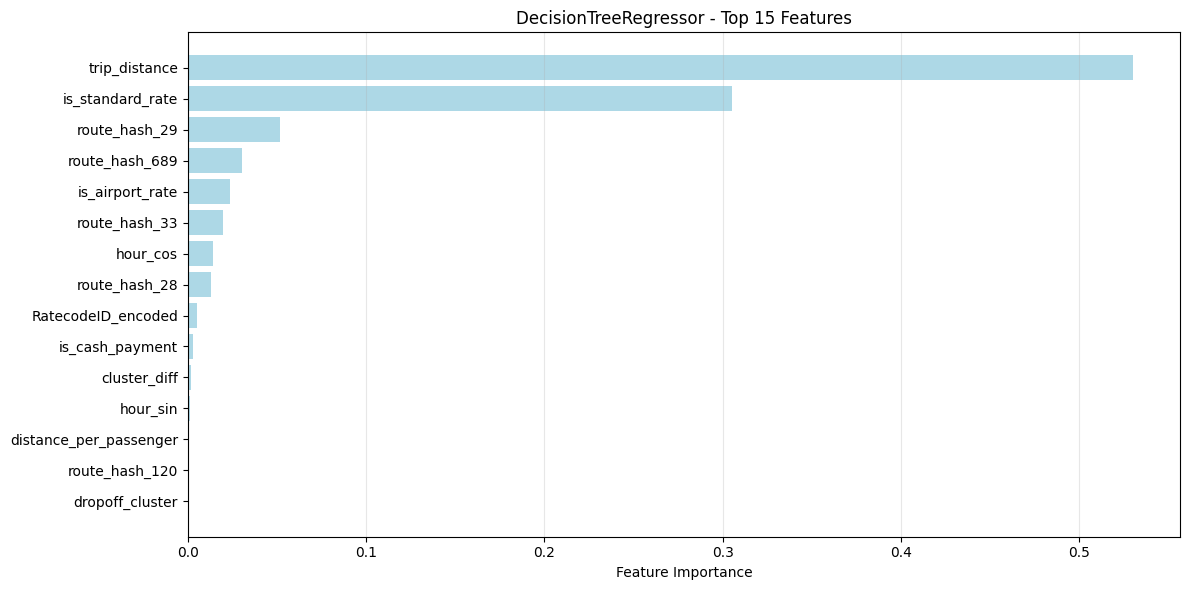


=== GBTRegressor Top Features ===
 1. trip_distance             (  1): 0.2624
 2. is_standard_rate          ( 20): 0.1319
 3. hour_sin                  (  2): 0.0703
 4. hashed_route_28           ( 28): 0.0702
 5. hour_cos                  (  3): 0.0639
 6. hashed_route_33           ( 33): 0.0523
 7. hashed_route_689          (689): 0.0305
 8. is_cash_payment           ( 18): 0.0279
 9. is_airport_rate           ( 19): 0.0276
10. passenger_count           (  0): 0.0258
11. hashed_route_29           ( 29): 0.0207
12. hashed_route_37           ( 37): 0.0173
13. rush_hour_distance        ( 22): 0.0169
14. dow_cos                   (  5): 0.0167
15. hashed_route_31           ( 31): 0.0146


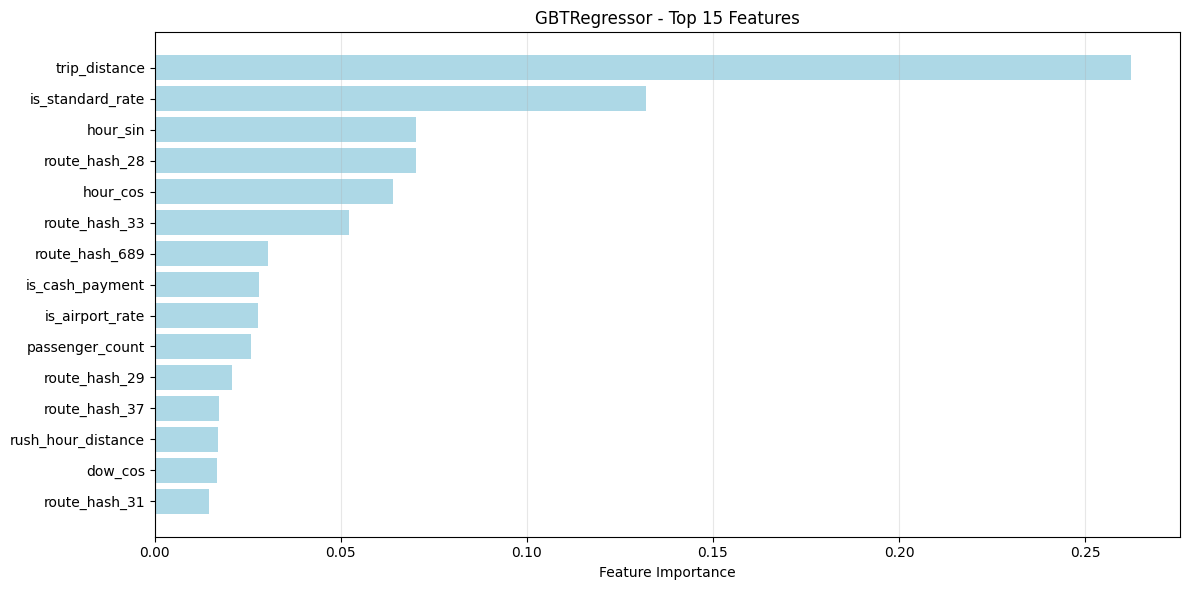

In [50]:
# Define tree-based models that have feature importance
tree_models = ["RandomForestRegressor", "DecisionTreeRegressor", "GBTRegressor"]

# Create feature name mapping
feature_names_map = {}
idx = 0

# Add numeric features (0-23)
for col in numeric_cols:
    feature_names_map[idx] = col
    idx += 1

# Add one-hot encoded features (24-33)
for col in low_card_cols:
    feature_names_map[idx] = f"{col}_encoded"
    idx += 1

# Remaining are hashed features (34+)
print("Features 0-23: Numeric features")
print("Features 24-33: One-hot encoded categorical")
print("Features 34+: Hashed route combinations")

# Extract and visualize feature importance for each tree-based model
for model_name in tree_models:
    if model_name in trained_models:
        print(f"\n=== {model_name} Top Features ===")
        
        model = trained_models[model_name]
        importances = model.featureImportances.toArray()
        
        # Get top 15 features with names
        top_indices = importances.argsort()[-15:][::-1]
        
        for i, idx in enumerate(top_indices):
            feature_name = feature_names_map.get(idx, f"hashed_route_{idx}")
            print(f"{i+1:2d}. {feature_name:25s} ({idx:3d}): {importances[idx]:.4f}")
        
        # Create plot
        plt.figure(figsize=(12, 6))
        feature_labels = [feature_names_map.get(idx, f"route_hash_{idx}") for idx in top_indices]
        
        plt.barh(range(len(top_indices)), importances[top_indices], color='lightblue')
        plt.yticks(range(len(top_indices)), feature_labels)
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Top 15 Features')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

### Visualize residual analysis plots

RandomForestRegressor - Mean residual: -0.034, Std: 5.438
DecisionTreeRegressor - Mean residual: -0.040, Std: 6.173
GBTRegressor - Mean residual: -0.066, Std: 5.628


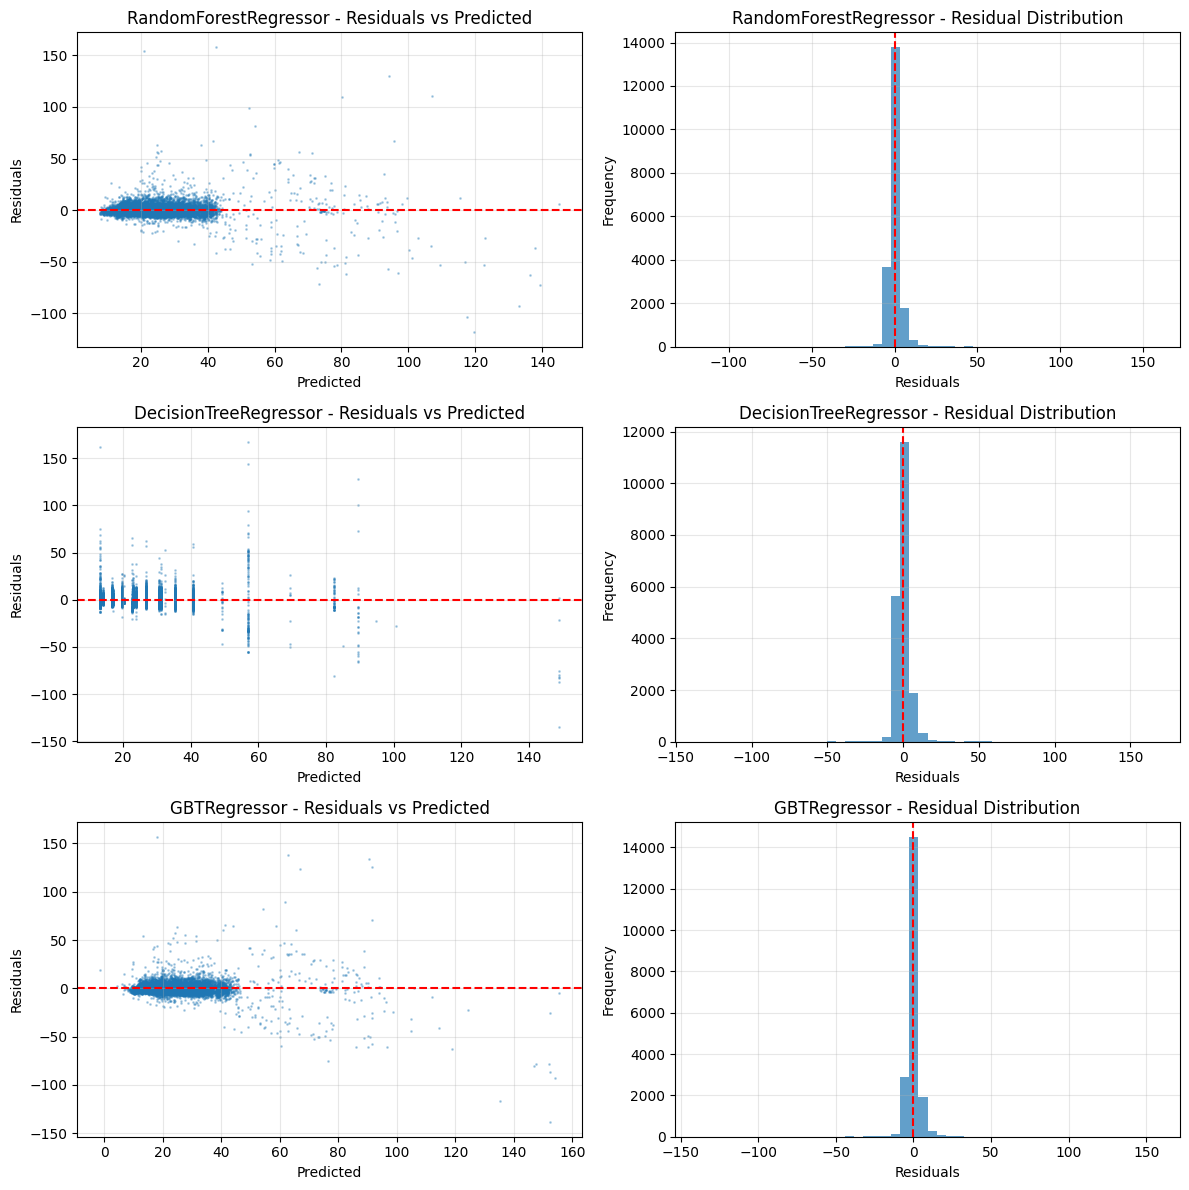

In [51]:
# Create residual plots for all tree models
fig, axes = plt.subplots(len(tree_models), 2, figsize=(12, 4*len(tree_models)))

for i, model_name in enumerate(tree_models):
    # Get predictions
    predictions_df = baseline_predictions[model_name].select('total_amount', 'prediction').toPandas()
    predictions_df['residuals'] = predictions_df['total_amount'] - predictions_df['prediction']
    
    # Residuals vs Predicted
    axes[i, 0].scatter(predictions_df['prediction'], predictions_df['residuals'], alpha=0.3, s=1)
    axes[i, 0].axhline(y=0, color='red', linestyle='--')
    axes[i, 0].set_xlabel('Predicted')
    axes[i, 0].set_ylabel('Residuals')
    axes[i, 0].set_title(f'{model_name} - Residuals vs Predicted')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Residual histogram
    axes[i, 1].hist(predictions_df['residuals'], bins=50, alpha=0.7)
    axes[i, 1].axvline(x=0, color='red', linestyle='--')
    axes[i, 1].set_xlabel('Residuals')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].set_title(f'{model_name} - Residual Distribution')
    axes[i, 1].grid(True, alpha=0.3)
    
    # Print stats
    print(f"{model_name} - Mean residual: {predictions_df['residuals'].mean():.3f}, Std: {predictions_df['residuals'].std():.3f}")

plt.tight_layout()
plt.show()

### Compare model performance

In [52]:
# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(baseline_results, columns=['Model', 'RMSE', 'MAE', 'R2'])
print("Model Performance Summary:")
print(results_df)

Model Performance Summary:
                         Model      RMSE       MAE        R2
0             LinearRegression  5.849346  2.832048  0.681417
1        RandomForestRegressor  5.438392  2.596189  0.724610
2        DecisionTreeRegressor  6.172545  3.199147  0.645239
3                 GBTRegressor  5.627988  2.650083  0.705073
4  GeneralizedLinearRegression  5.849346  2.832048  0.681417


In [53]:
# Create a performance ranking table
performance_ranking = results_df.copy()

# Rank models (1 = best)
performance_ranking['RMSE_Rank'] = performance_ranking['RMSE'].rank()
performance_ranking['MAE_Rank'] = performance_ranking['MAE'].rank()
performance_ranking['R2_Rank'] = performance_ranking['R2'].rank(ascending=False)

# Calculate average rank
performance_ranking['Avg_Rank'] = (
    performance_ranking['RMSE_Rank'] + 
    performance_ranking['MAE_Rank'] + 
    performance_ranking['R2_Rank']
) / 3

# Sort by average rank
performance_ranking = performance_ranking.sort_values('Avg_Rank')

print("\n" + "="*70)
print("MODEL PERFORMANCE RANKING (1 = Best)")
print("="*70)
print(performance_ranking[['Model', 'RMSE', 'MAE', 'R2', 'RMSE_Rank', 'MAE_Rank', 'R2_Rank', 'Avg_Rank']].to_string(index=False))


MODEL PERFORMANCE RANKING (1 = Best)
                      Model     RMSE      MAE       R2  RMSE_Rank  MAE_Rank  R2_Rank  Avg_Rank
      RandomForestRegressor 5.438392 2.596189 0.724610        1.0       1.0      1.0       1.0
               GBTRegressor 5.627988 2.650083 0.705073        2.0       2.0      2.0       2.0
           LinearRegression 5.849346 2.832048 0.681417        3.0       3.0      3.0       3.0
GeneralizedLinearRegression 5.849346 2.832048 0.681417        4.0       4.0      4.0       4.0
      DecisionTreeRegressor 6.172545 3.199147 0.645239        5.0       5.0      5.0       5.0


### Get best model

In [54]:
# Create residual plots for the best model
best_model = performance_ranking.iloc[0]['Model']
best_predictions = baseline_predictions[best_model].select('total_amount', 'prediction').toPandas()

In [55]:
# Export the best model
import os

best_model_name = performance_ranking.iloc[0]['Model']
best_model_obj = trained_models[best_model_name]

# Create directory if it doesn't exist
os.makedirs("trained_models", exist_ok=True)
best_model_path = f"trained_models/{best_model_name}_best"

# Save the best model
best_model_obj.write().overwrite().save(best_model_path)
print(f"Best model '{best_model_name}' exported to {best_model_path}")

Best model 'RandomForestRegressor' exported to trained_models/RandomForestRegressor_best
